# 03 - Normalization & Scaling Evaluation

**Input:** `Collaborator1/diabetes_clean.csv`

**Outputs:**
- Summary of raw vs. z-score vs. min-max ranges.
- Histograms + boxplots for both scalers.
- Recommendation + optional export of the normalized dataset.


## 1 - Setup, Imports & Dataset Load
In this section we load the cleaned dataset, separate predictors from the binary `outcome`, and keep the raw dataframe intact. This sets up a clean feature matrix for scaling and avoids any leakage from the target label.


In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set_palette("Set2")

DATA_PATH = Path('../data/processed/diabetes_clean.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError('../data/processed/diabetes_clean.csv not found relative to repo root.')

df = pd.read_csv(DATA_PATH)
feature_cols = df.columns.drop('outcome')
df[feature_cols].head()


,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age
0,6,148,72,35,30.5,33.6,0.6270,50
1,1,85,66,29,30.5,26.6,0.3510,31
2,8,183,64,23,30.5,23.3,0.6720,32
3,1,89,66,23,94.0,28.1,0.1670,21
4,0,137,40,35,168.0,43.1,0.3725,33


## 2 - Distribution Check
In this section we review percentiles and skewness to understand the shape of each feature. This helps us anticipate whether min-max scaling will compress most values when a feature has a long tail, and it provides context for why we need scaling before modeling.


In [2]:
summary = (
    df[feature_cols]
    .describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    .T.loc[:, ["mean", "std", "min", "5%", "50%", "95%", "max"]]
)
summary


,mean,std,min,5%,50%,95%,max
pregnancies,3.782552,3.270644,0.000,0.00000,3.00000,10.0000,13.000
glucose,121.656250,30.438286,44.000,80.00000,117.00000,181.0000,199.000
blood_pressure,72.108073,10.874178,40.000,54.00000,72.00000,90.0000,104.000
skin_thickness,26.278646,7.493445,10.000,15.00000,23.00000,41.0000,45.000
insulin,70.755534,59.661471,14.000,30.50000,30.87500,200.0000,272.000
bmi,32.198958,6.410558,18.200,22.23500,32.00000,43.5000,50.000
diabetes_pedigree,0.427667,0.245162,0.078,0.14035,0.37175,0.9222,1.191
age,32.760417,11.055385,21.000,21.00000,29.00000,56.0000,66.000


As we can see in the summary table, the predictors have very different ranges and variability. Insulin tends to have the widest spread and strongest skew, while features like glucose and BMI are mid-range, and pregnancies behaves like a discrete count. This confirms that raw values are not directly comparable and motivates scaling before modeling.


## 3 - Fit StandardScaler vs. MinMaxScaler
Here we apply two common scaling approaches on the same predictor matrix so we can compare their effects directly.
- **Z-score:** `(x - mean) / std`
- **Min-max:** rescale to `[0, 1]` based on min/max


In [3]:
scalers = {
    "Z-score": StandardScaler(),
    "Min-Max (0-1)": MinMaxScaler(),
}

scaled_frames = {}
for name, scaler in scalers.items():
    scaled_frames[name] = pd.DataFrame(
        scaler.fit_transform(df[feature_cols]),
        columns=feature_cols,
    )

stack = [("Raw", df[feature_cols])] + list(scaled_frames.items())
long_df = (
    pd.concat({name: frame for name, frame in stack}, names=["scale"])
    .reset_index(level=0)
    .rename(columns={"level_0": "scale"})
    .melt(id_vars="scale", var_name="feature", value_name="value")
)
long_df.head()


,scale,feature,value
0,Raw,pregnancies,6.0
1,Raw,pregnancies,1.0
2,Raw,pregnancies,8.0
3,Raw,pregnancies,1.0
4,Raw,pregnancies,0.0


## 4 - Compare Numeric Summaries Under Each Scaling
In this section we compare how raw ranges and percentiles change after scaling. This makes it clear which method preserves relative distances and which one compresses skewed features.


In [4]:
comparison = pd.DataFrame({
    "Raw mean": df[feature_cols].mean(),
    "Raw std": df[feature_cols].std(),
    "Raw min": df[feature_cols].min(),
    "Raw max": df[feature_cols].max(),
    "Z-score mean": scaled_frames["Z-score"].mean(),
    "Z-score std": scaled_frames["Z-score"].std(),
    "Min-Max min": scaled_frames["Min-Max (0-1)"].min(),
    "Min-Max 95%": scaled_frames["Min-Max (0-1)"].quantile(0.95),
    "Min-Max max": scaled_frames["Min-Max (0-1)"].max(),
})
comparison.loc[["insulin", "glucose", "age", "bmi"]]


,Raw mean,Raw std,Raw min,Raw max,Z-score mean,Z-score std,Min-Max min,Min-Max 95%,Min-Max max
insulin,70.755534,59.661471,14.0,272.0,-1.087093e-16,1.000652,0.0,0.720930,1.0
glucose,121.656250,30.438286,44.0,199.0,4.625929e-18,1.000652,0.0,0.883871,1.0
age,32.760417,11.055385,21.0,66.0,2.035409e-16,1.000652,0.0,0.777778,1.0
bmi,32.198958,6.410558,18.2,50.0,-6.129356e-16,1.000652,0.0,0.795597,1.0


From the comparison table we can see that z-score scaling standardizes every predictor (mean near 0, std near 1). In contrast, the min-max 95th percentile values for skewed features are well below 1.0, which means most observations are squeezed into a narrow band while a few large values define the maximum. This is exactly the compression we expected for insulin and age.


## 5 - Visual Comparison
We visualize raw vs. scaled distributions to see whether scaling preserves shape. Histograms and boxplots help confirm what we observe in the numeric summaries.


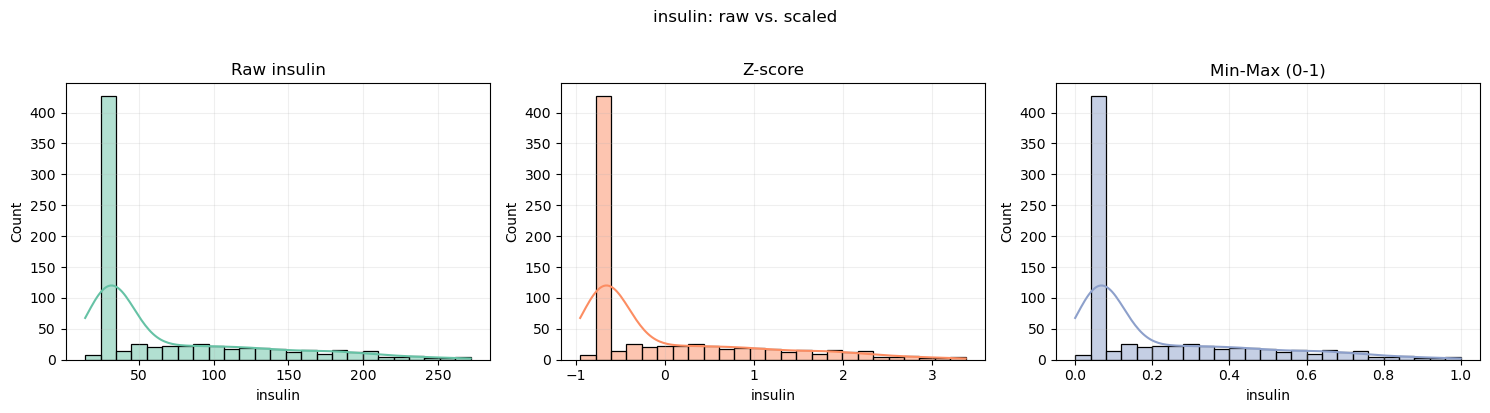

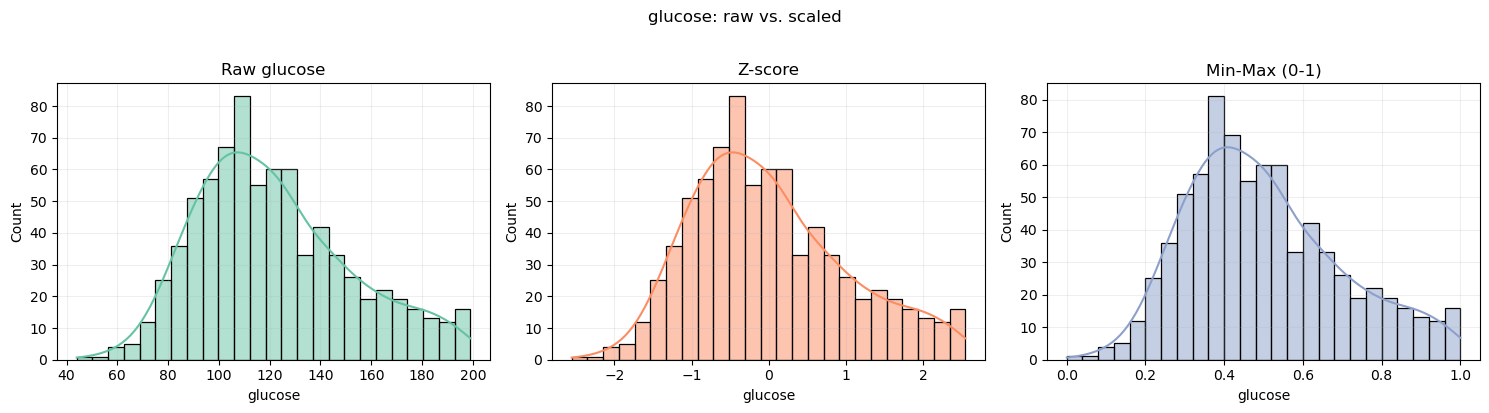

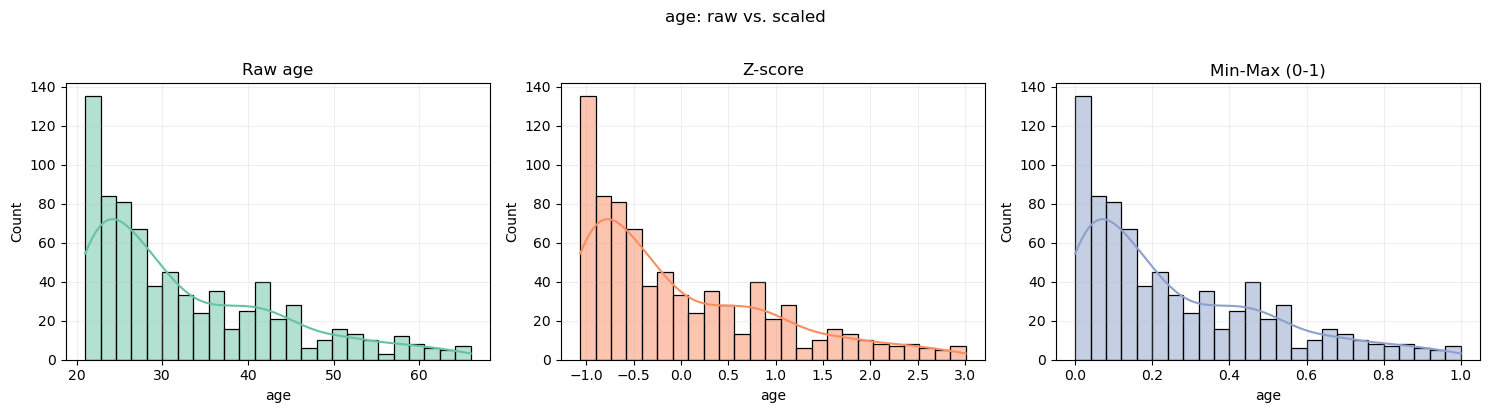

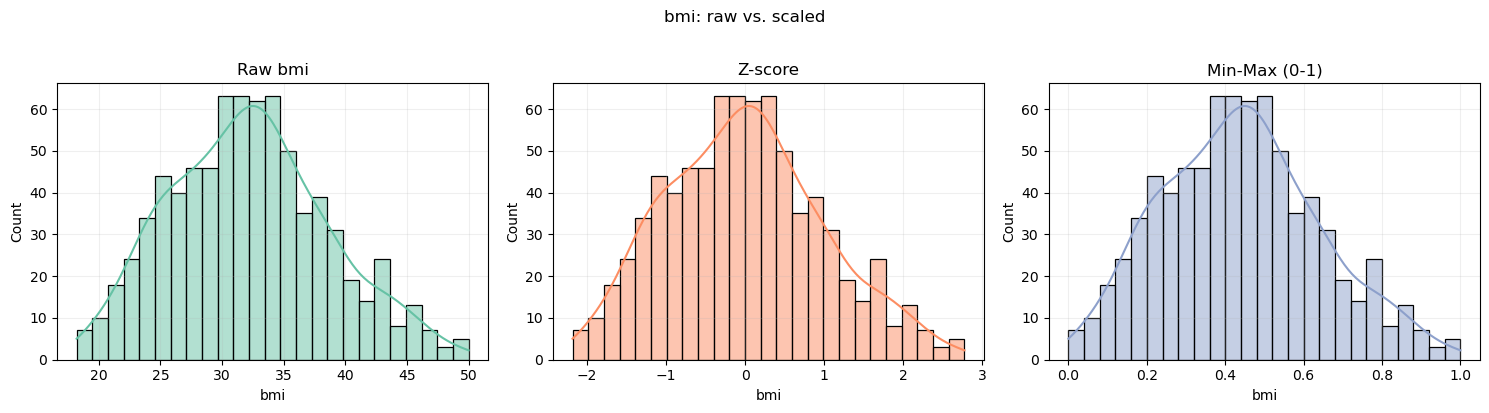

In [5]:
palette = sns.color_palette("Set2", 3)
raw_color = palette[0]
scaled_colors = palette[1:]

def compare_feature(feature):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(df, x=feature, bins=25, kde=True, ax=axes[0], color=raw_color)
    axes[0].set_title(f"Raw {feature}")

    for ax, color, (name, frame) in zip(
        axes[1:], scaled_colors, scaled_frames.items()
    ):
        sns.histplot(frame, x=feature, bins=25, kde=True, ax=ax, color=color)
        ax.set_title(name)

    for ax in axes:
        ax.grid(alpha=0.2)

    fig.suptitle(f"{feature}: raw vs. scaled", y=1.02)
    plt.tight_layout()


for feature in ["insulin", "glucose", "age", "bmi"]:
    compare_feature(feature)


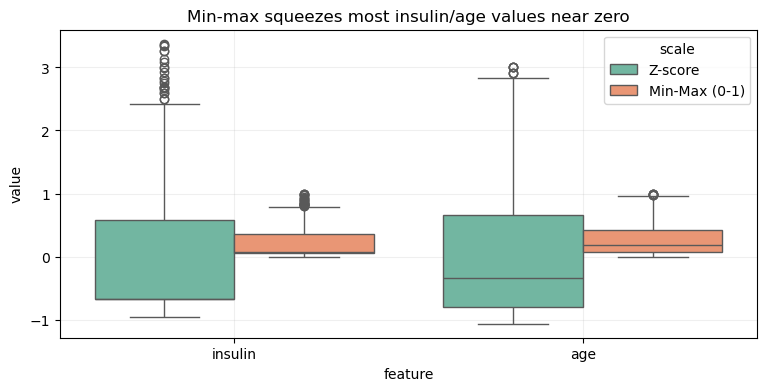

In [6]:
plt.figure(figsize=(9, 4))
sns.boxplot(
    data=long_df[
        (long_df["scale"] != "Raw") & (long_df["feature"].isin(["insulin", "age"]))
    ],
    x="feature",
    y="value",
    hue="scale",
    palette="Set2",
)
plt.title("Min-max squeezes most insulin/age values near zero")
plt.grid(alpha=0.2)
plt.show()


The histograms show that z-score scaling preserves the shape of each distribution while re-centering and re-scaling it. Min-max scaling forces all values into `[0, 1]`, which makes skewed features appear more concentrated near zero. The boxplot highlights this effect for insulin and age, where most values sit close to the lower bound after min-max.


## 6 - Interpretation & Recommendation
Based on the summary statistics and visuals, z-score normalization is the safer choice for this dataset. It keeps each predictor on a comparable variance scale without flattening most of the values, and it aligns with common model assumptions (LR, SVM, NN).

**Decision:** use StandardScaler; keep `outcome` unchanged.


In [8]:
export_df = scaled_frames["Z-score"].copy()
export_df["outcome"] = df["outcome"].values
export_path = Path("../data/processed/diabetes_all_columns_normalized.csv")
export_df.to_csv(export_path, index=False)
export_path


PosixPath('../data/processed/diabetes_all_columns_normalized.csv')

## 7 – Correlation-Based Feature Redundancy Analysis


In [12]:
corr = scaled_frames["Z-score"].corr().abs()

upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr = [
    col for col in upper_tri.columns
    if any(upper_tri[col] > 0.75)
]

high_corr


[]

A conservative correlation threshold of |r| > 0.75 was used to identify strongly redundant predictors. Under this criterion, no variable pairs were found to be highly correlated after z-score normalization. This indicates that the predictors do not exhibit strong linear redundancy and that each feature captures a distinct aspect of patient physiology. In contrast to the Jitter/Shimmer example, where multiple variables measure overlapping acoustic properties, the diabetes predictors appear largely complementary.


In [15]:
moderate_corr = [
    col for col in upper_tri.columns
    if any(upper_tri[col] > 0.5)
]
moderate_corr


['age']

To further assess potential overlap, the correlation threshold was relaxed to |r| > 0.5, capturing moderate associations. Under this criterion, age emerged as the only variable exhibiting moderate correlation with another predictor. This result suggests the presence of expected demographic relationships rather than strong feature redundancy.

In [17]:
age_corr = (
    scaled_frames["Z-score"]
    .corr()
    .loc["age"]
    .abs()
    .sort_values(ascending=False)
)

age_corr[age_corr > 0.5]



age            1.000000
pregnancies    0.560768
Name: age, dtype: float64

Inspecting the correlations involving age shows that its strongest association is with pregnancies. This relationship is clinically intuitive, as pregnancy count naturally increases with age. Importantly, age and pregnancies represent related but distinct clinical concepts and therefore are not interchangeable. Their moderate correlation reflects demographic structure rather than duplicated information.

In summary, correlation-based redundancy analysis was performed using a conservative threshold (|r| > 0.75) as the primary criterion for feature reduction. A relaxed threshold (|r| > 0.5) was examined solely for exploratory purposes and was not adopted for decision-making. Since no strong redundancy was detected and the observed moderate associations were clinically meaningful, all predictors were retained. This ensures that the normalized dataset remains both statistically sound and interpretable for downstream analysis.